In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

class Mesh2D:
    def __init__(self, domain=((0, 1), (0, 1))):
        self.xmin, self.xmax = domain[0]
        self.ymin, self.ymax = domain[1]
        self.points = None
        self.triangles = None
        self.grid_shape = None
        self.k = None
        self.nx = None
        self.ny = None
        self.vertical_lines = []
        self.horizontal_lines = []
        self.primal_points = []
        self.dual_points = []
        self.subdomain_indices = {}

    def _factor_k(self, k):
        for i in range(int(math.sqrt(k)), 0, -1):
            if k % i == 0:
                return i, k // i
        return 1, k

    def get_ordered_points(self, side_x=10, side_y=10):
        x = np.linspace(self.xmin, self.xmax, side_x)
        y = np.linspace(self.ymin, self.ymax, side_y)
        xx, yy = np.meshgrid(x, y)
        self.points = np.vstack([xx.ravel(), yy.ravel()]).T
        self.grid_shape = (side_y, side_x)

    def triangulate(self):
        ny, nx = self.grid_shape
        triangles = []
        for j in range(ny - 1):
            for i in range(nx - 1):
                p0 = j * nx + i
                p1 = p0 + 1
                p2 = p0 + nx
                p3 = p2 + 1
                triangles.append([p0, p1, p3])
                triangles.append([p0, p3, p2])
        self.triangles = np.array(triangles)

    def divide_domain(self, k):
        self.k = k
        self.nx, self.ny = self._factor_k(k)
        self.vertical_lines.clear()
        self.horizontal_lines.clear()
        self.primal_points.clear()
        self.dual_points.clear()
        self.subdomain_indices.clear()

        vx = [self.xmin + i * (self.xmax - self.xmin) / self.nx for i in range(1, self.nx)]
        hy = [self.ymin + i * (self.ymax - self.ymin) / self.ny for i in range(1, self.ny)]

        self.vertical_lines = [((x, self.ymin), (x, self.ymax)) for x in vx]
        self.horizontal_lines = [((self.xmin, y), (self.xmax, y)) for y in hy]

        tolerance = 1e-6
        primal = []
        dual = []

        for idx, (px, py) in enumerate(self.points):
            on_v = any(np.isclose(px, x, atol=tolerance) for x in vx)
            on_h = any(np.isclose(py, y, atol=tolerance) for y in hy)
            if on_v and on_h:
                primal.append(idx)
            elif on_v or on_h:
                dual.append(idx)

        self.primal_points = np.array(primal)
        self.dual_points = np.array(dual)

        ny, nx = self.grid_shape
        x_idx = np.linspace(self.xmin, self.xmax, nx)
        y_idx = np.linspace(self.ymin, self.ymax, ny)

        sx = []
        sy = []

        step_x = int(nx/self.nx)
        arr_x = []
        for i in range(0,nx,step_x):
            arr_x.append(i)

        for i in range(len(arr_x)):
            if i != 0:
                sx.append(np.array(range(arr_x[i-1],arr_x[i]+1)))

        step_y = int(ny/self.ny)
        arr_y = []
        for i in range(0,ny,step_y):
            arr_y.append(i)

        for i in range(len(arr_y)):
            if i != 0:
                sy.append(np.array(range(arr_y[i-1],arr_y[i]+1)))

        for i in range(self.nx):
            for j in range(self.ny):
                sub_points = []
                for yi in sy[j]:
                    for xi in sx[i]:
                        index = yi * nx + xi
                        sub_points.append(index)
                s_index = j * self.nx + i
                self.subdomain_indices[s_index] = sub_points

    def plot_triangulation(self):
        plt.figure(figsize=(6, 6))
        for tri in self.triangles:
            pts = self.points[tri]
            plt.plot(*zip(*(pts[[0, 1, 2, 0]])), color='black', linewidth=0.8)
        plt.scatter(self.points[:, 0], self.points[:, 1], c='red', s=8)
        plt.title("Structured Triangulation")
        plt.axis("equal")
        plt.grid(False)
        plt.show()

    def plot_subdomains_and_points(self):
        plt.figure(figsize=(6, 6))

        for tri in self.triangles:
            pts = self.points[tri]
            plt.plot(*zip(*(pts[[0, 1, 2, 0]])), color='lightgray')

        for line in self.vertical_lines + self.horizontal_lines:
            plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'k--', linewidth=1)

        if len(self.dual_points) > 0:
            plt.scatter(self.points[self.dual_points][:, 0], self.points[self.dual_points][:, 1], c='blue', label='Dual Points')
        if len(self.primal_points) > 0:
            plt.scatter(self.points[self.primal_points][:, 0], self.points[self.primal_points][:, 1], c='red', label='Primal Points')

        plt.scatter(self.points[:, 0], self.points[:, 1], c='black', s=10, alpha=0.3, label='All Points')
        plt.title(f'Subdomains (k={self.k}) with Primal (Red) and Dual (Blue) Points')
        plt.axis('equal')
        plt.legend()
        plt.grid(False)
        plt.show()

    def plot_phi_function(self, subdomain_index, phi_index_in_subdomain):
        if subdomain_index not in self.subdomain_indices:
            raise ValueError(f"Subdomain {subdomain_index} not found.")

        sub_points = self.subdomain_indices[subdomain_index]
        phi_point_global_idx = sub_points[phi_index_in_subdomain]

        z = np.zeros(len(self.points))
        z[phi_point_global_idx] = 1.0

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')

        for tri in self.triangles:
            if all(v in sub_points for v in tri):
                tri_pts = self.points[tri]
                zz = z[tri]
                color = 'yellow' if 1.0 in zz else 'skyblue'
                alpha_val = 0.8 if 1.0 in zz else 0.5 
                ax.plot_trisurf(tri_pts[:, 0], tri_pts[:, 1], zz,
                                color=color, edgecolor='black', linewidth=0.5, alpha=alpha_val)

        ax.set_title(f"Phi_{phi_index_in_subdomain} in Subdomain {subdomain_index}")
        plt.tight_layout()
        plt.show()


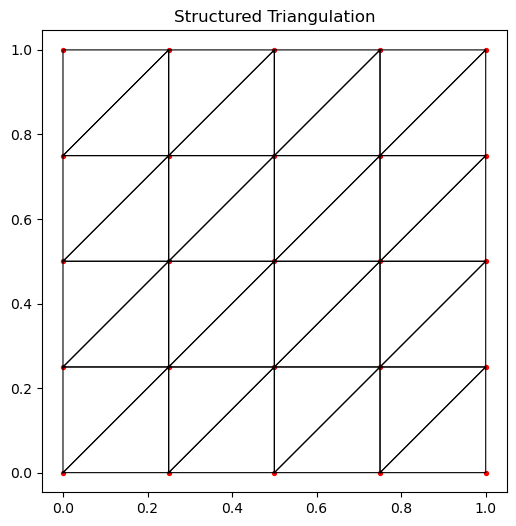

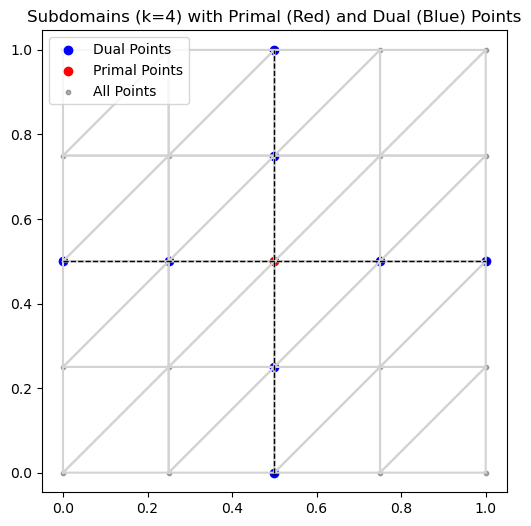

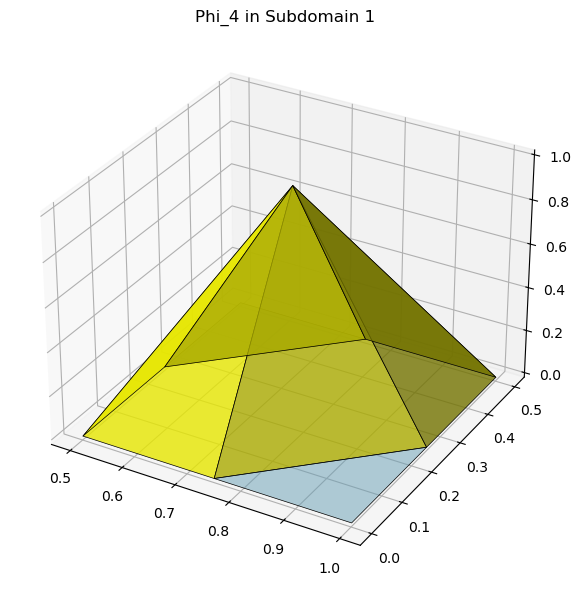

In [2]:


mesh = Mesh2D()
mesh.get_ordered_points(side_x=5, side_y=5)
mesh.triangulate()
mesh.divide_domain(k=4)  # Divide into 4 subdomains
mesh.plot_triangulation()
mesh.plot_subdomains_and_points()
mesh.plot_phi_function(subdomain_index=1, phi_index_in_subdomain=4)
